# Final Dissertation - Modelling Missing Values in Medical Time Series Data

Pooja Bhande (s5228784)
* MSc. Data Science and Artificial Intelligence



In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from datetime import datetime
from datetime import timedelta
import dask.dataframe as da
import seaborn as sns
%matplotlib inline
import missingno as msno
from quilt.data.ResidentMario import missingno_data
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import NearMiss
from sklearn.utils import resample
from keras.utils import np_utils

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')



We will connect to PostGre SQL to access the MIMIC-III database

In [2]:
# information used to create a database connection
sqluser = 'postgres'
sqlpass = 'pooja'
dbname = 'mimic'
schema_name = 'public,mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, password=sqlpass)

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

From the MIMIC-III database we have downloaded the Vital Signs csv file to extract the required features for our dataset. Due to the large size of the files, we will be using a combination of SQL queries and python data manipulations for processing the dataset.
Here we are downloading the saved csv file and for the next file, we will be directly querying it from MIMIC-III database stored  PostGreSQL

In [3]:
#Reading Vital signs reading csv file
df_vitals = pd.read_csv("E:\Dataset\pivoted\pivoted_vital.csv",)
df_vitals

,icustay_id,charttime,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose
0,226006,2131-03-20 12:00:00,80.0,NaN,NaN,NaN,17.0,37.166667,97.0,NaN
1,226006,2131-03-20 13:00:00,74.0,NaN,NaN,NaN,15.0,NaN,96.0,NaN
2,226006,2131-03-20 14:00:00,75.0,NaN,NaN,NaN,13.0,NaN,97.0,NaN
3,226006,2131-03-20 14:09:00,NaN,123.0,67.0,80.0,NaN,NaN,NaN,NaN
4,226006,2131-03-20 15:00:00,74.0,105.0,61.0,70.0,16.0,NaN,95.0,NaN
...,...,...,...,...,...,...,...,...,...,...
9152805,226006,2131-03-20 08:40:00,NaN,138.0,91.0,104.0,NaN,NaN,NaN,NaN
9152806,226006,2131-03-20 09:00:00,82.0,107.0,67.0,77.0,13.0,NaN,97.0,NaN
9152807,226006,2131-03-20 10:00:00,81.0,NaN,NaN,72.0,13.0,NaN,98.0,155.0
9152808,226006,2131-03-20 11:00:00,79.0,NaN,NaN,80.0,14.0,NaN,97.0,NaN


The next required database table is queried from the database and saved in a dataframe

In [4]:
#Reading the ICU Stays table to identify the patient id 
query = query_schema + """
SELECT subject_id, hadm_id, icustay_id
FROM icustays
"""
df_icustays = pd.read_sql_query(query, con)
df_icustays.head()

,subject_id,hadm_id,icustay_id
0,268,110404,280836
1,269,106296,206613
2,270,188028,220345
3,271,173727,249196
4,272,164716,210407


Now from the two tables retrieved we are linking the subject id column to the Vital Signs dataframe, this column will be later required to associate the mortality status of the patient

In [5]:
#Adding the subject Id column to the vitals table - required later for linking the mortality status  
df = pd.merge(df_vitals,df_icustays[['icustay_id','subject_id']], on='icustay_id', how='left')
df = df[['charttime','icustay_id','subject_id','HeartRate','SysBP','DiasBP','MeanBP','RespRate','TempC','SpO2','Glucose']]
df

,charttime,icustay_id,subject_id,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose
0,2131-03-20 12:00:00,226006,81763,80.0,NaN,NaN,NaN,17.0,37.166667,97.0,NaN
1,2131-03-20 13:00:00,226006,81763,74.0,NaN,NaN,NaN,15.0,NaN,96.0,NaN
2,2131-03-20 14:00:00,226006,81763,75.0,NaN,NaN,NaN,13.0,NaN,97.0,NaN
3,2131-03-20 14:09:00,226006,81763,NaN,123.0,67.0,80.0,NaN,NaN,NaN,NaN
4,2131-03-20 15:00:00,226006,81763,74.0,105.0,61.0,70.0,16.0,NaN,95.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9152805,2131-03-20 08:40:00,226006,81763,NaN,138.0,91.0,104.0,NaN,NaN,NaN,NaN
9152806,2131-03-20 09:00:00,226006,81763,82.0,107.0,67.0,77.0,13.0,NaN,97.0,NaN
9152807,2131-03-20 10:00:00,226006,81763,81.0,NaN,NaN,72.0,13.0,NaN,98.0,155.0
9152808,2131-03-20 11:00:00,226006,81763,79.0,NaN,NaN,80.0,14.0,NaN,97.0,NaN


Here we are removing entries where there are two or less measurements records on a time stamp

In [6]:
df = df.dropna(how='all', subset=['HeartRate','SysBP','DiasBP','MeanBP','RespRate','TempC','SpO2','Glucose'])
#df['charttime'] = pd.to_datetime(df['charrtime'],errors = 'coerce')
#df = df.set_index('charttime')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9140407 entries, 0 to 9152809
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   charttime   object 
 1   icustay_id  int64  
 2   subject_id  int64  
 3   HeartRate   float64
 4   SysBP       float64
 5   DiasBP      float64
 6   MeanBP      float64
 7   RespRate    float64
 8   TempC       float64
 9   SpO2        float64
 10  Glucose     float64
dtypes: float64(8), int64(2), object(1)
memory usage: 836.8+ MB


With the removal of records with less than 2 measurements, dataset size was reduced by almost ~12000 records

Patient Mortality Status Extraction:

A expire_flag records whether a patient died or not in the hospital in the Patients Table. It is set to 1 if died and 0 otherwise.
To determine the adult mortality rate, we need to first select the adult population. The adult population considered for this project are patients above the age of 15 years or older at the time of thier admission in the hospital. 

To perform this query, the Patients and Admissions table is used to find the patient admission date and thier date of birth. The patients are further categorized into 3 groups of ">89", 'adult' and 'neonatal'.  

We are connecting to the MIMIC-III database from PostGre SQL to extract the required records and the resultant table is stored in dataframe - 'mortality'

In [7]:
#Extracting the adult patient mortality status

query = query_schema + """
WITH first_admission_time AS
(
  SELECT
      p.subject_id, p.dob, p.expire_flag, p.gender
      , MIN (a.admittime) AS first_admittime
      , MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,2) )
          AS first_admit_age
  FROM mimiciii.patients p
  INNER JOIN mimiciii.admissions a
  ON p.subject_id = a.subject_id
  GROUP BY p.subject_id, p.dob, p.expire_flag, p.gender
  ORDER BY p.subject_id
)
SELECT
    subject_id, dob
    , first_admittime, first_admit_age, gender
    , CASE
        -- all ages > 89 in the database were replaced with 300
        WHEN first_admit_age > 89
            then '>89'
        WHEN first_admit_age > 14 and first_admit_age <=89
            THEN 'adult'
        WHEN first_admit_age <= 1
            THEN 'neonate'
        ELSE 'middle'
        END AS age_group, expire_flag
FROM first_admission_time
ORDER BY subject_id
"""
mortality = pd.read_sql_query(query, con)
mortality


,subject_id,dob,first_admittime,first_admit_age,gender,age_group,expire_flag
0,2,2138-07-17,2138-07-17 19:04:00,0.00,M,neonate,0
1,3,2025-04-11,2101-10-20 19:08:00,76.52,M,adult,1
2,4,2143-05-12,2191-03-16 00:28:00,47.84,F,adult,0
3,5,2103-02-02,2103-02-02 04:31:00,0.00,M,neonate,0
4,6,2109-06-21,2175-05-30 07:15:00,65.94,F,adult,0
...,...,...,...,...,...,...,...
46515,99985,2127-04-08,2181-01-27 02:47:00,53.81,M,adult,0
46516,99991,2137-04-07,2184-12-24 08:30:00,47.72,M,adult,0
46517,99992,2078-10-17,2144-07-25 18:03:00,65.77,F,adult,0
46518,99995,2058-05-29,2147-02-08 08:00:00,88.70,F,adult,1


Selecting only the adult population to include in the study populuation

In [8]:
#filtering the mortality list of patients aged above 15 and less than 89 (age_group = Adult)
mortality = mortality[mortality['age_group'] == 'adult']
mortality

,subject_id,dob,first_admittime,first_admit_age,gender,age_group,expire_flag
1,3,2025-04-11,2101-10-20 19:08:00,76.52,M,adult,1
2,4,2143-05-12,2191-03-16 00:28:00,47.84,F,adult,0
4,6,2109-06-21,2175-05-30 07:15:00,65.94,F,adult,0
7,9,2108-01-26,2149-11-09 13:06:00,41.79,M,adult,1
9,11,2128-02-22,2178-04-16 06:18:00,50.15,F,adult,1
...,...,...,...,...,...,...,...
46515,99985,2127-04-08,2181-01-27 02:47:00,53.81,M,adult,0
46516,99991,2137-04-07,2184-12-24 08:30:00,47.72,M,adult,0
46517,99992,2078-10-17,2144-07-25 18:03:00,65.77,F,adult,0
46518,99995,2058-05-29,2147-02-08 08:00:00,88.70,F,adult,1


In [9]:
df_all = pd.merge(df,mortality[['first_admit_age','gender','expire_flag','subject_id']], on='subject_id',how='inner')

To allow for ease of comparison, individual data is condensed into hourly observations by selecting the mean value of the available observations within each hour. Upon resampling the dataset into hourly observations, there will be records with Nan marked on all the columns on the timestamp where there was no measurements recorded originally, only such rows have been eliminated from the dataset.

In [10]:
#keeping a copy of the dataframe with all the variables
df1 = df_all.copy()

#changing the type of charttime to DataTime field and setting it as index
df1['charttime'] = pd.to_datetime(df1['charttime'],errors = 'coerce')
df1 = df1.set_index('charttime')

#converting the Gender column to numerical values
df1['gender'].replace({'M':1, 'F':0}, inplace=True)

#variables list
variables = ['subject_id','HeartRate','SysBP','DiasBP','MeanBP','RespRate','TempC','SpO2','Glucose', 'first_admit_age','gender','expire_flag']
ts_variables = ['HeartRate','SysBP','DiasBP','MeanBP','RespRate','TempC','SpO2','Glucose']

#Resampling the data into hourly observations.
df1 = df1.groupby('icustay_id')[variables].resample('1H').mean()

#removing the rows with all null values (on hourly time stamps where no data was recorded will be saved as 
#null entry when resample method is applied, deleting such entries from the dataset)
df1 = df1.dropna(how='all')

Now let's have a look at the hourly sampled dataset

In [11]:
df1

subject_id  HeartRate  SysBP  DiasBP  \
icustay_id charttime                                                   
200001     2181-11-25 19:00:00     55973.0      114.5  113.0    65.0   
           2181-11-25 20:00:00     55973.0      113.0  110.0    65.0   
           2181-11-25 21:00:00     55973.0      108.0  113.0    68.0   
           2181-11-25 22:00:00     55973.0      110.0  116.0    68.0   
           2181-11-25 23:00:00     55973.0      102.0  102.0    61.0   
...                                    ...        ...    ...     ...   
299999     2117-09-01 11:00:00      7630.0       68.0  100.0    46.0   
           2117-09-01 12:00:00      7630.0       71.0  104.0    42.0   
           2117-09-01 13:00:00      7630.0       72.0  105.0    50.0   
           2117-09-01 14:00:00      7630.0       70.0  104.0    48.0   
           2117-09-01 15:00:00      7630.0       70.0  105.0    49.0   

                                   MeanBP  RespRate      TempC  SpO2  Glucose  \
icustay_id charttime                                                            
200001     2181-11-25 19:00:00  77.000000      24.0  37.277778  94.5      NaN   
           2181-11-25 20:00:00  76.000000      20.0        NaN  97.0      NaN   
           2181-11-25 21:00:00  79.000000      18.0        NaN  98.0      NaN   
           2181-11-25 22:00:00  79.000000      27.0        NaN  98.0    118.0   
           2181-11-25 23:00:00  71.000000      21.0  37.666667  96.0      NaN   
...                                   ...       ...        ...   ...      ...   
299999     2117-09-01 11:00:00  64.000000      21.0  37.444445  96.0      NaN   
           2117-09-01 12:00:00  62.666698      25.0        NaN  96.0      NaN   
           2117-09-01 13:00:00  68.333298      25.0        NaN  97.0    130.0   
           2117-09-01 14:00:00  66.666702      22.0        NaN  95.0      NaN   
           2117-09-01 15:00:00  67.666702      24.0        NaN  94.0      NaN   

                                first_admit_age  gender  expire_flag  
icustay_id charttime                                                  
200001     2181-11-25 19:00:00            59.98     0.0          1.0  
           2181-11-25 20:00:00            59.98     0.0          1.0  
           2181-11-25 21:00:00            59.98     0.0          1.0  
           2181-11-25 22:00:00            59.98     0.0          1.0  
           2181-11-25 23:00:00            59.98     0.0          1.0  
...                                         ...     ...          ...  
299999     2117-09-01 11:00:00            48.73     1.0          0.0  
           2117-09-01 12:00:00            48.73     1.0          0.0  
           2117-09-01 13:00:00            48.73     1.0          0.0  
           2117-09-01 14:00:00            48.73     1.0          0.0  
           2117-09-01 15:00:00            48.73     1.0          0.0  

[4762842 rows x 12 columns]

For the purpose of our project evaluation, the measurements from last 48 hours of patient's ICU stay before discharge or in-hospital death has been considered. To perform this processing, all patients with ICU stays greater than 48 hours are filtered out first and from those patients, the last 48 recordings are extracted. 

In [12]:
#Taking the count of each patient's ICU stay durations in the hospital
df1 = df1.reset_index(level = [0,1])
count = df1.groupby(by='icustay_id').agg('count')

#Filtering the patients with stay greater than 48 hours
count = count[count['charttime']>=48]

#extracting the ids of the stays greater than 48 and saving it to a list
ids = count.index.tolist()

#creating a new dataframe and adding only observations of 48 hours
df_final = df1.query('icustay_id in @ids') 
df_final = df_final.sort_values('charttime').groupby('icustay_id').tail(48)

#Adding a time step to the dataset for data analysis purpose
df_final['time_step'] = df_final.groupby('icustay_id').cumcount()


# Exploratory Data Analysis

Now that we processed the database and acquired the final dataset fit to perform our experiments, lets proceed to explore the properties of this data collected. 

We will first begin by looking at the complete dataset review followed by the review of missingness in the dataset.

Lets look at the Data distribution in the final dataset after the pre-processing

In [13]:
df_final.describe()

,icustay_id,subject_id,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose,first_admit_age,gender,expire_flag,time_step
count,1.236864e+06,1.236864e+06,1.222651e+06,1.168056e+06,1.167796e+06,1.166058e+06,1.200171e+06,354087.000000,1.152076e+06,245952.000000,1.236864e+06,1.236864e+06,1.236864e+06,1.236864e+06
mean,2.499078e+05,3.534960e+04,8.535634e+01,1.223552e+02,6.095147e+01,7.926130e+01,2.006375e+01,36.903141,9.667239e+01,141.526957,6.330681e+01,5.679137e-01,4.891338e-01,2.350000e+01
std,2.882697e+04,2.864865e+04,1.685716e+01,2.241778e+01,1.450807e+01,1.585681e+01,5.704326e+00,0.744558,3.546129e+00,57.117592,1.606010e+01,4.953665e-01,4.998821e-01,1.385340e+01
min,2.000010e+05,3.000000e+00,2.000000e+00,2.000000e-01,5.000000e-01,4.300000e-01,1.000000e+00,17.400000,5.000000e-01,0.142000,1.518000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.249655e+05,1.256675e+04,7.300000e+01,1.060000e+02,5.100000e+01,6.800000e+01,1.600000e+01,36.444444,9.500000e+01,107.000000,5.307000e+01,0.000000e+00,0.000000e+00,1.175000e+01
50%,2.499840e+05,2.541250e+04,8.400000e+01,1.205000e+02,6.000000e+01,7.800000e+01,2.000000e+01,36.888890,9.700000e+01,129.000000,6.543000e+01,1.000000e+00,0.000000e+00,2.350000e+01
75%,2.748052e+05,5.753750e+04,9.600000e+01,1.370000e+02,7.000000e+01,8.900000e+01,2.300000e+01,37.333333,9.900000e+01,160.000000,7.631250e+01,1.000000e+00,1.000000e+00,3.525000e+01
max,2.999940e+05,9.999500e+04,2.250000e+02,3.400000e+02,2.850000e+02,2.980000e+02,6.900000e+01,42.250000,1.000000e+02,2901.000000,8.900000e+01,1.000000e+00,1.000000e+00,4.700000e+01


In [14]:
#Checking the count of ICU stay Ids in the final datasets

print('Number of unique ICU stays:',df_final.icustay_id.nunique())
print('Total no. patients:',df_final.subject_id.nunique())

#checking the Gender proportion in the study population by grouping on unique subject ids
gender_count = pd.DataFrame(df_final.groupby('subject_id')['gender'].value_counts())
gender_count.drop('gender', inplace=True, axis=1)
gender_count = gender_count.reset_index(level=[0,1])

print('% of male patients:',(len(gender_count[gender_count['gender']==1])/len(gender_count))*100,'%')
print('% of female patients:',(len(gender_count[gender_count['gender']==0])/len(gender_count))*100,'%')

Number of unique ICU stays: 25768
Total no. patients: 20337
% of male patients: 56.90613168117225 %
% of female patients: 43.09386831882775 %


Let's look at the Mortality Ratio in the dataset

In [15]:
#grouping the mortality status based on the subject ids, since there are same patients admitted for multiple ICU stays

mortality_count = pd.DataFrame(df_final.groupby('subject_id')['expire_flag'].value_counts())
mortality_count.drop('expire_flag', inplace=True, axis=1)
mortality_count = mortality_count.reset_index(level=[0,1])

print('Number of survivors: ',mortality_count.expire_flag.value_counts()[0])
print('Number of non survivors:',mortality_count.expire_flag.value_counts()[1])

#Percentage of survivors vs non-survivors in the dataset

print('% of survivors: ',round((mortality_count.expire_flag.value_counts()[0])/(len(mortality_count))*100,2),'%')
print('% of non survivors:',round((mortality_count.expire_flag.value_counts()[1])/(len(mortality_count))*100,2),'%')

Number of survivors:  11134
Number of non survivors: 9203
% of survivors:  54.75 %
% of non survivors: 45.25 %


# Missing Values Rate and Properties:

The focus of our project is to model the missingness factor of the variables, we will begin with looking at the percentage of missing values in the processed dataset.

"missingno" visualization toolkit has been used to review and analyze the missing data features 

In [16]:
#Firstly we look at the non-null count of all the variables in the dataset.
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236864 entries, 1055849 to 1629365
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   icustay_id       1236864 non-null  int64         
 1   charttime        1236864 non-null  datetime64[ns]
 2   subject_id       1236864 non-null  float64       
 3   HeartRate        1222651 non-null  float64       
 4   SysBP            1168056 non-null  float64       
 5   DiasBP           1167796 non-null  float64       
 6   MeanBP           1166058 non-null  float64       
 7   RespRate         1200171 non-null  float64       
 8   TempC            354087 non-null   float64       
 9   SpO2             1152076 non-null  float64       
 10  Glucose          245952 non-null   float64       
 11  first_admit_age  1236864 non-null  float64       
 12  gender           1236864 non-null  float64       
 13  expire_flag      1236864 non-null  float64       
 

In [17]:
#Here wer are checking the percentage of missing values for each of the time series variables

In [18]:

frac=[]
count=[]
for i in df_final[ts_variables]:
    temp1 = df_final[i].isnull().sum()
    temp = round ((temp1/len(df_final[i])*100),2)
    frac.append(temp)
    count.append(temp1)

percentage = pd.DataFrame(ts_variables, columns=['Time_Series_Variables'])
percentage['No. of missing values'] = count
percentage['Fraction missing %'] = frac
percentage

,Time_Series_Variables,No. of missing values,Fraction missing %
0,HeartRate,14213,1.15
1,SysBP,68808,5.56
2,DiasBP,69068,5.58
3,MeanBP,70806,5.72
4,RespRate,36693,2.97
5,TempC,882777,71.37
6,SpO2,84788,6.86
7,Glucose,990912,80.11


<AxesSubplot:>

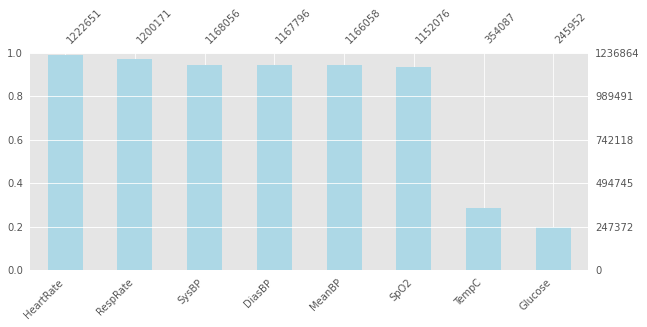

In [19]:
#plotting the missing values in a bar plot
msno.bar(df_final[ts_variables], color='lightblue', figsize=(10,4),fontsize=10, sort='descending')

Now let's have a look at the missing rate for all the measurements considered for modelling. To understand the missing patterns for each variable, lets first review a single patient data.


<AxesSubplot:>

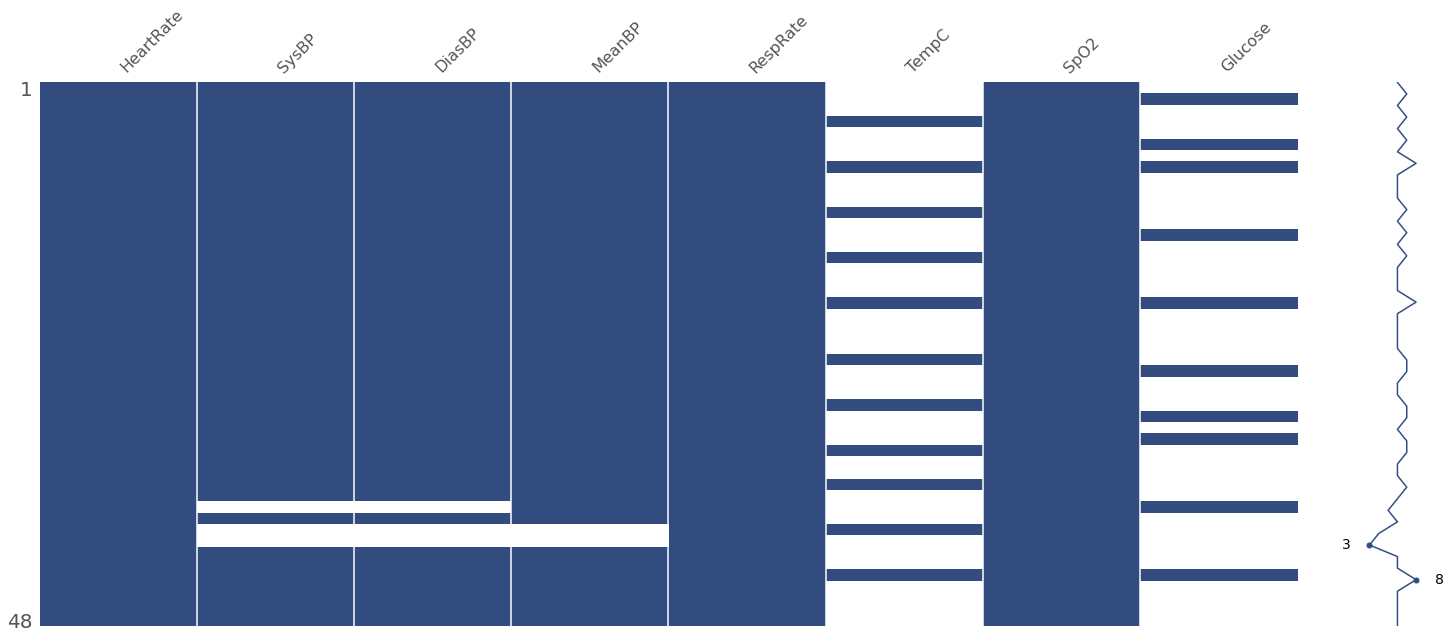

In [20]:
#using the missingno matrix to look at the data-density display in the sample set
msno.matrix(df_final[df_final['icustay_id']==226006][ts_variables], color=(0.2,0.3,0.5))


From the initial analysis for a single patient, we see Heart Rate, Respiratory Rate and SpO2 are recorded throughout the 48-hour duration, as seen in the original raw dataset, these readings are collected every 15 to 30 mins and by condensing them to hourly measurements has resulted in no missing values for these measurements.

Next set of measurements seen with fewer missing values are Blood pressure readings, we see these readings are highly co-related as these are the readings normally collected in pairs. Mean BP is the resultant value of both these readings and is found missing every time these two values are also missing. 

Finally coming to the features which have the highest missing rates in this sample data - Temperature and Glucose. As initially observed in the raw dataset, these measurements are recorded at a lower level of frequency compared to other measurements, hence the higher rate of missing values in the 48-hour window. We see the collection of Temperature reading is quite uniform, again this variable falls under the MNAR category. The data is missing due to pre-determined intervals of collection. 



Missing Values Heatmap:

We will now have a look at the missing number corelation heatmap which demonstrates how strongly the presence or absence of one variable affects the presence of another. We will look at the same sample set


<AxesSubplot:>

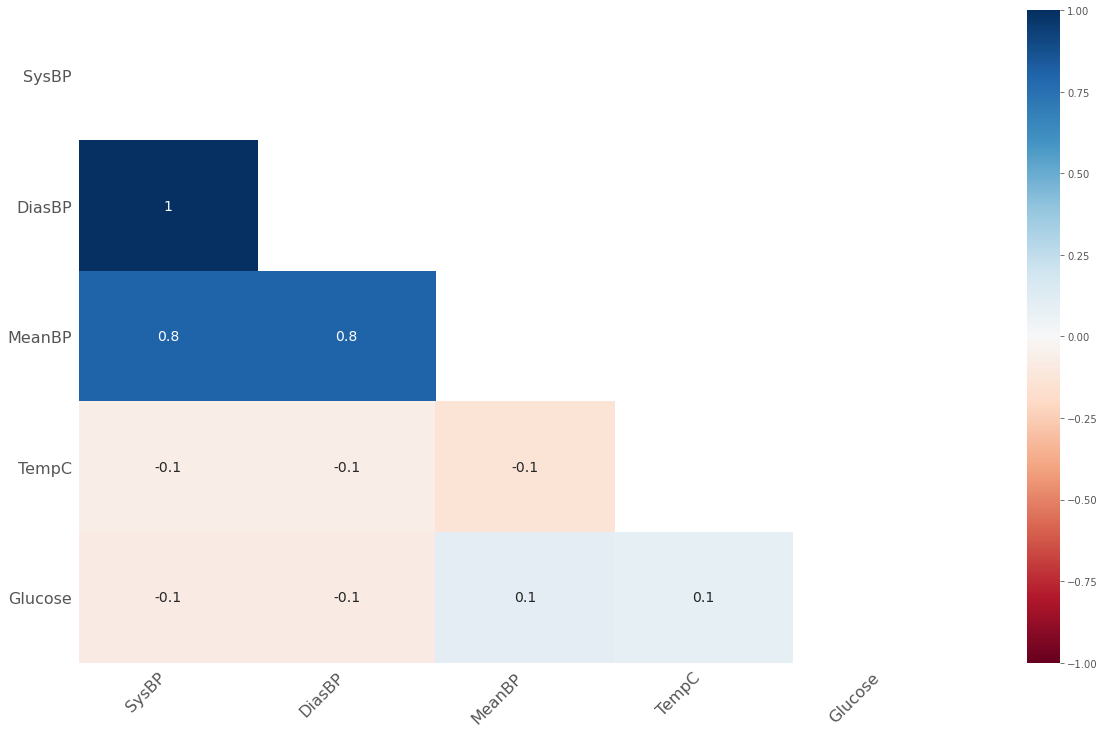

In [21]:
msno.heatmap(df_final[df_final['icustay_id']==226006])

From the figure above we can see that some of the features have been excluded from the matrix, this is because the variables which are complete or are fully empty have no meaningful corelation. From the features available we can see that the pattern followed in Blood Pressure readings reflecting the actual reality, with these 2 variables being highly corelated with value =1. Also another observation we can make from this visualization is that although not highly corelated, we see temperature being negatively and Glucose positively corelated with the blood pressure measurements. 

Let's look at another visualization which illustrates the degree of corelation beyond the pairwise corelation seen above

<AxesSubplot:>

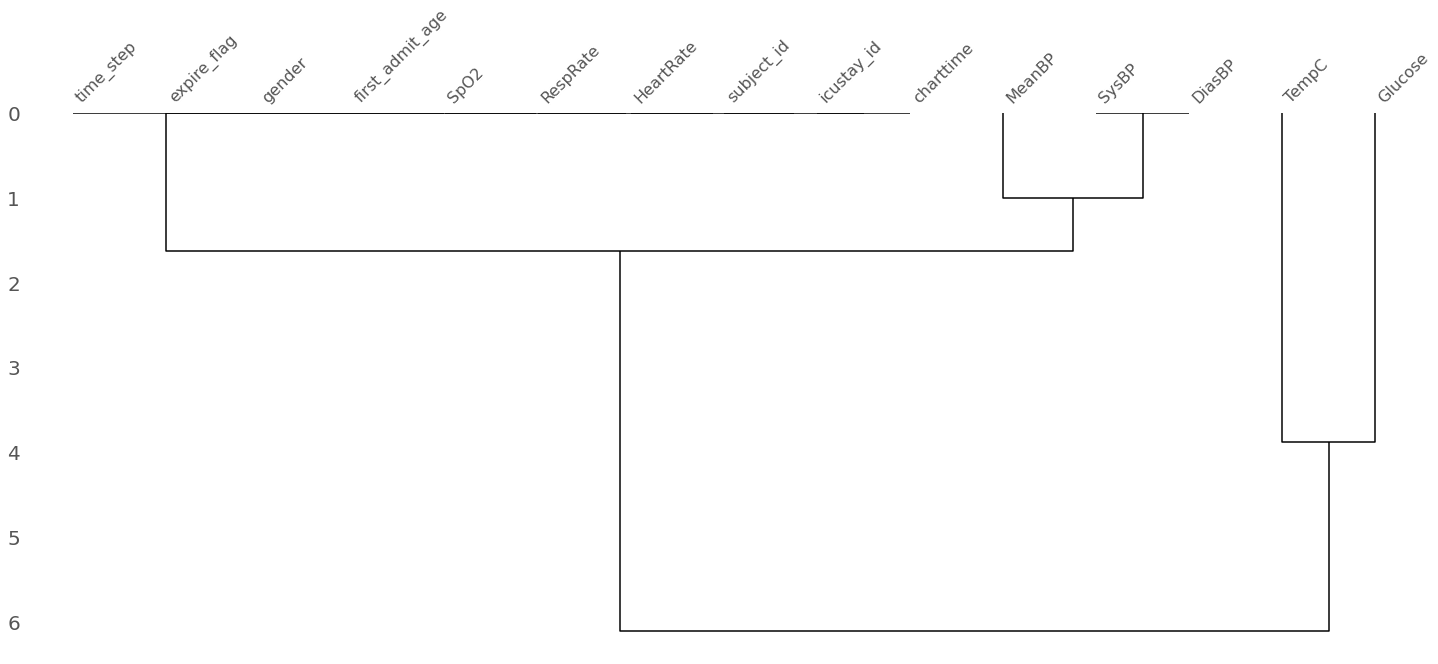

In [22]:
msno.dendrogram(df_final[df_final['icustay_id']==226006])

The dendrogram uses hierarchical clustering algorithm to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.

This plot does not reveal anything further from what we already observed in the visulaizations before this. It can make more sense when we look at complete dataset.

Moving to the complete dataset, let's look at the missing rate of variables in the complete dataset

<AxesSubplot:>

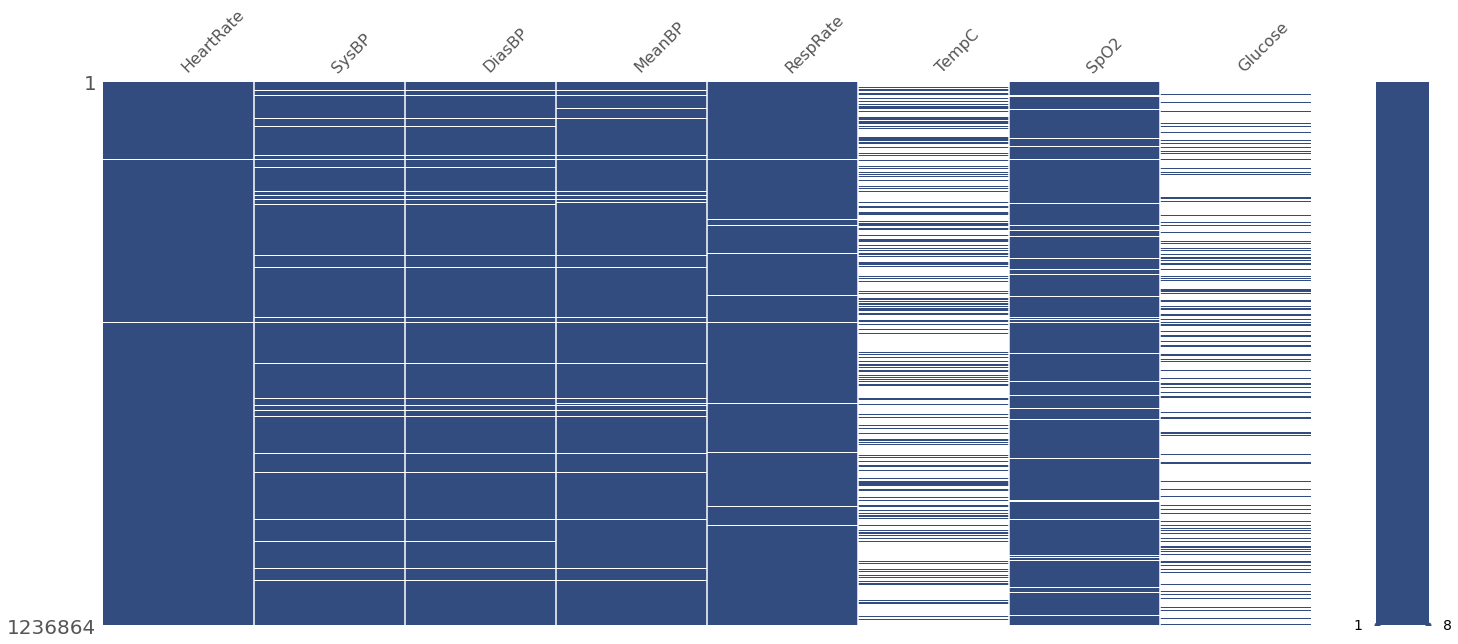

In [23]:
# looking at missing rate in only the time series variables
msno.matrix(df_final[ts_variables], color=(0.2,0.3,0.5), figsize = (24,10))

From the above plot, we make following observations with respect to missingness:

1. Heart rate is the feature with least missing rate, followed by Respiratory rate where again the missing rate is pretty low. 
2. Next we see the Blood Pressure readings follow the same pattern as observed on single patient data sample.
3. We have a different observation for SpO2 readings on complete dataset, where the missing rate is quite high, when compared to single patient data sample. 
4. Lastly we see the same pattern repeating for Temperature and Glucose with highest missing rate compared to other variables.


<AxesSubplot:>

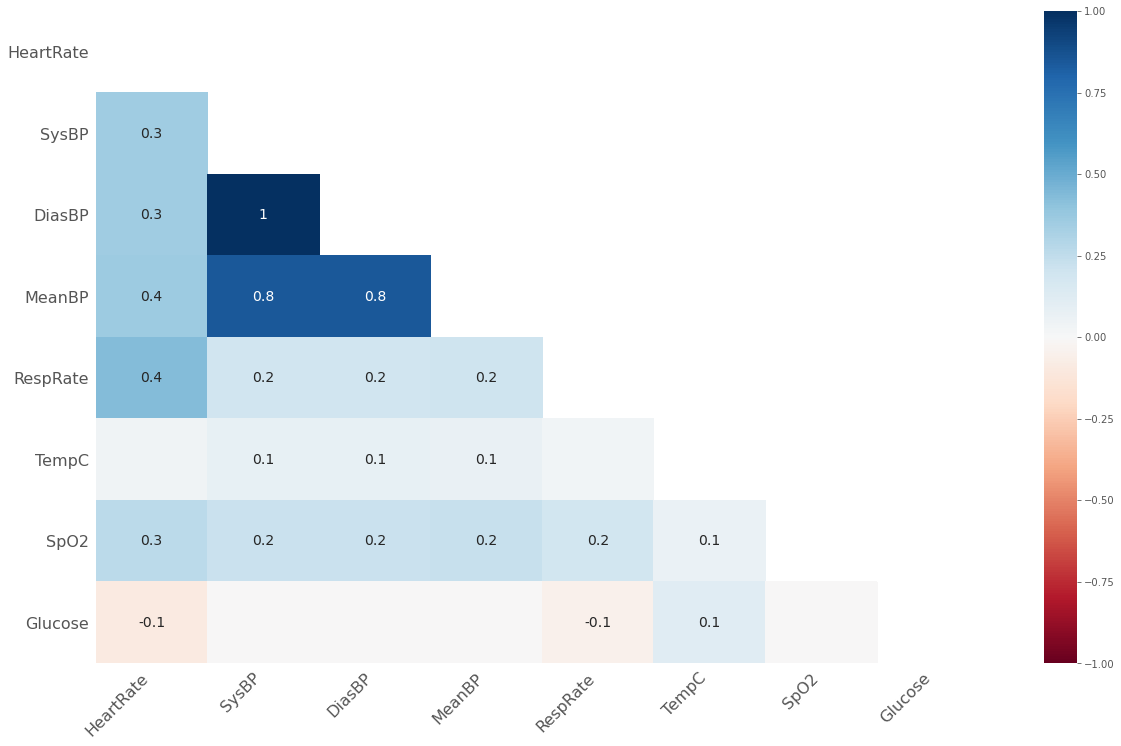

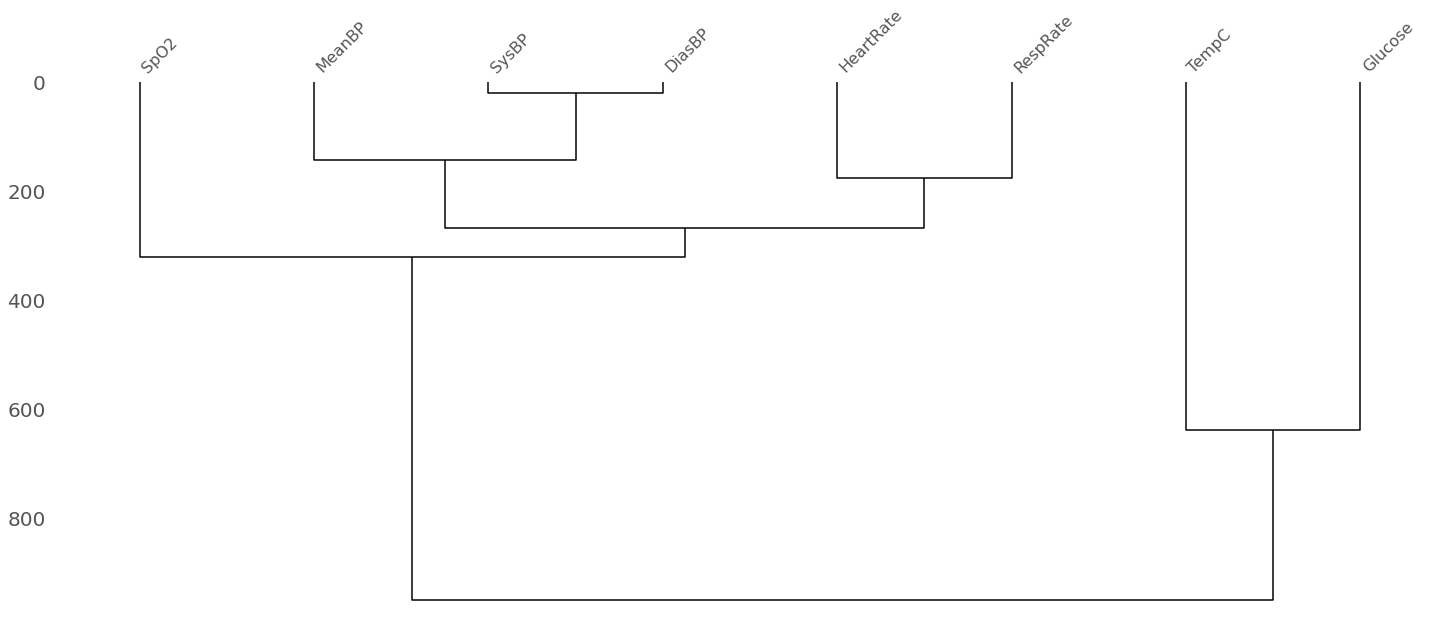

In [24]:
#now lets have a look at the missing co-relation and the dendogram matrix for the complete dataset
msno.heatmap(df_final[ts_variables],)
msno.dendrogram(df_final[ts_variables])

The above plots return similar inferences we observed in the first matrix. From the corelation matrix we can make one observation that although there is very low corelation amongst different variables, there is mostly positive missing corelation implying that at certain intervals of time, either sets of measurements are missing. This is not a meaningful insight, however we can see if our neural models can learn from this pattern. 
Also one another observation we can make from the dendrogram is with SpO2 where we see the missingness is collectively corelated with missing rates of Blood pressure, Heart Rate and Respiratory values. 

The remaining part of the project implementation is continued in Google Colab.

In [25]:
#Copying the processed dataset to continue with the implementation in Google Colab
df_final.to_csv('df_final.csv')